Epoch 0, Avg Loss: 0.103366
Epoch 50, Avg Loss: 0.000002
Epoch 99, Avg Loss: 0.000001


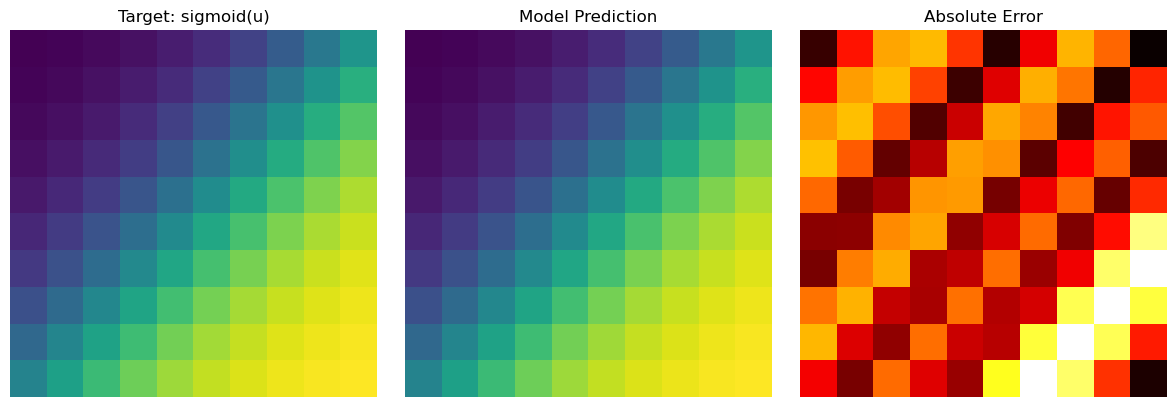

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

# === Tu red ===
class Explanatory(nn.Module):
    def __init__(self, input_size, n_filters, hidden_layer_size, output_size):
        super(Explanatory, self).__init__()
        self.in_size = torch.tensor(input_size)
        self.n_filters = n_filters
        self.h_layer = hidden_layer_size
        self.out_size = torch.tensor(output_size)

        self.conv_expand_layer = nn.Conv2d(in_channels=1, out_channels=self.n_filters, kernel_size=1)
        self.hidden_layer_1 = nn.Linear(self.n_filters, self.h_layer)
        self.hidden_layer_2 = nn.Linear(self.h_layer, self.n_filters)
        self.conv_converge_layer = nn.Conv2d(in_channels=self.n_filters, out_channels=1, kernel_size=1)

    def forward(self, X):
        batch_size, _, height, width = X.shape
        X = self.conv_expand_layer(X)
        X = X.permute(0, 2, 3, 1).reshape(-1, self.n_filters)
        X = torch.sigmoid(self.hidden_layer_1(X))
        X = torch.sigmoid(self.hidden_layer_2(X))
        X = X.reshape(batch_size, height, width, self.n_filters).permute(0, 3, 1, 2)
        output = self.conv_converge_layer(X)
        return output

# === Dataset personalizado ===
class SigmoidDataset(Dataset):
    def __init__(self, num_samples=100, H=10, W=10):
        self.inputs = []
        self.targets = []
        x = np.linspace(-1, 1, W)
        y = np.linspace(-1, 1, H)
        xx, yy = np.meshgrid(x, y)

        for _ in range(num_samples):
            a = np.random.uniform(-1, 1)
            b = np.random.uniform(-5, 5)
            c = np.random.uniform(-5, 5)
            u = a + b * xx + c * yy
            sig_u = 1 / (1 + np.exp(-u))

            input_tensor = torch.tensor(u, dtype=torch.float32).unsqueeze(0)   # (1, H, W)
            target_tensor = torch.tensor(sig_u, dtype=torch.float32).unsqueeze(0)
            self.inputs.append(input_tensor)
            self.targets.append(target_tensor)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# === Entrenamiento con múltiples ejemplos ===
def train_model(model, dataloader, epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}, Avg Loss: {total_loss / len(dataloader):.6f}")

# === Visualización de una muestra ===
def plot_example(model, dataset):
    input_tensor, target_tensor = dataset[0]
    input_tensor = input_tensor.unsqueeze(0)  # add batch dim
    with torch.no_grad():
        output = model(input_tensor)

    pred = output.squeeze().numpy()
    target = target_tensor.squeeze().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(target, cmap='viridis')
    axs[0].set_title("Target: sigmoid(u)")
    axs[1].imshow(pred, cmap='viridis')
    axs[1].set_title("Model Prediction")
    axs[2].imshow(np.abs(pred - target), cmap='hot')
    axs[2].set_title("Absolute Error")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# === MAIN ===
if __name__ == "__main__":
    dataset = SigmoidDataset(num_samples=100)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    model = Explanatory(input_size=(1, 10, 10), n_filters=8, hidden_layer_size=16, output_size=(1, 10, 10))
    train_model(model, dataloader)

    plot_example(model, dataset)

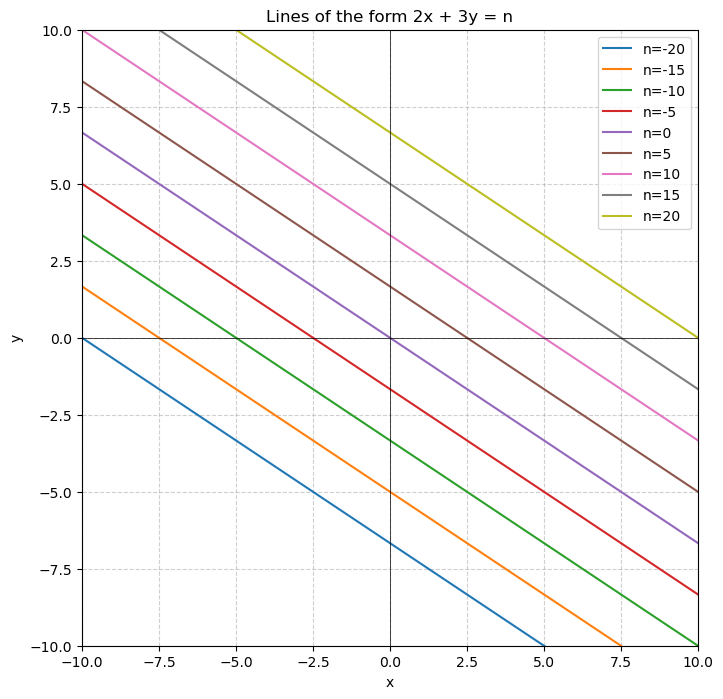

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Define x values
x = np.linspace(-10, 10, 400)

# Set range of integer n values
n_values = range(-20, 21, 5)  # from -20 to 20 in steps of 5

plt.figure(figsize=(8, 8))
for n in n_values:
    y = (n - 2 * x) / 3
    plt.plot(x, y, label=f'n={n}')

# Add plot details
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lines of the form 2x + 3y = n')
plt.legend()
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


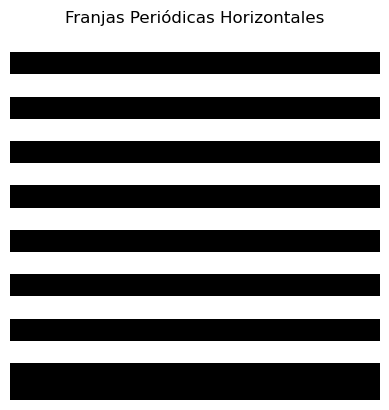

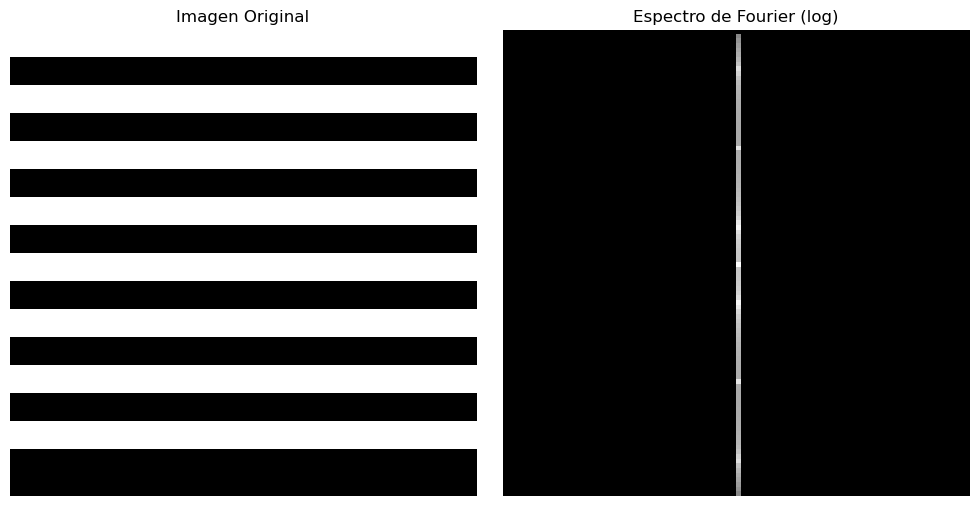

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Parámetros de la imagen
width, height = 100, 100
num_stripes = 16

# Crear una imagen con franjas horizontales periódicas
stripe_height = height // num_stripes
image = np.zeros((height, width), dtype=np.uint8)

for i in range(num_stripes):
    if i % 2 == 0:
        image[i * stripe_height:(i + 1) * stripe_height, :] = 255

# Mostrar la imagen
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Franjas Periódicas Horizontales')
plt.show()

# Calcular la Transformada Rápida de Fourier (FFT)
fft_result = np.fft.fft2(image)
fft_shifted = np.fft.fftshift(fft_result)
magnitude_spectrum = np.abs(fft_shifted)
magnitude_spectrum_log = np.log(1 + magnitude_spectrum)

# Mostrar el espectro de magnitud
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum_log, cmap='gray')
plt.title('Espectro de Fourier (log)')
plt.axis('off')

plt.tight_layout()
plt.show()

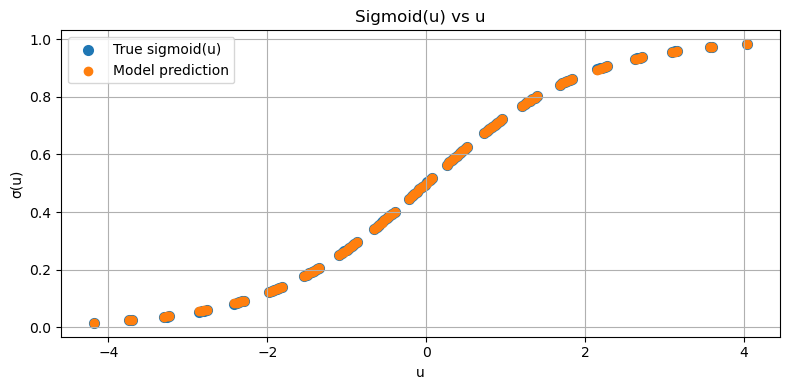

In [58]:

def plot_sigmoid_curve(model, dataset):
    input_tensor, target_tensor = dataset[0]
    u_vals = input_tensor.squeeze().numpy().flatten()
    true_sigmoid = target_tensor.squeeze().numpy().flatten()

    with torch.no_grad():
        model_output = model(input_tensor.unsqueeze(0)).squeeze().numpy().flatten()

    # Ordenar por u para graficar suavemente
    sorted_idx = np.argsort(u_vals)
    u_vals_sorted = u_vals[sorted_idx]
    true_sorted = true_sigmoid[sorted_idx]
    pred_sorted = model_output[sorted_idx]

    plt.figure(figsize=(8, 4))
    plt.scatter(u_vals, true_sigmoid, label='True sigmoid(u)', linewidth=2)
    plt.scatter(u_vals, model_output, label='Model prediction')
    plt.xlabel("u")
    plt.ylabel("σ(u)")
    plt.title("Sigmoid(u) vs u")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_sigmoid_curve(model, dataset)